In [ ]:
!pip install tensorflow

In [3]:
import tensorflow as tf

2024-06-22 10:44:28.906937: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-22 10:44:28.911396: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-22 10:44:29.001278: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-22 10:44:29.082341: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 10:44:30.067555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [126]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, ArrayType
from pyspark import SparkConf, SparkContext

from pyarrow import fs
import pyarrow
import pandas as pd
import json
import datetime
import os
import sys
import pyspark
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


from IPython.display import display, HTML
display(HTML("<style>.container {width:100% !important; }<style>"))

In [130]:
spark_config = {
    "spark.executor.instances": "8",
    "spark.executor.cores": "4",
    "spark.executor.memory": "16g",
    # "spark.sql.execution.arrow.enabled": True,
    # "spark.kryoserializer.buffer.max": "1536",
    "spark.debug.maxToStringFields": 100,
    "spark.sql.legacy.parquet.datetimeRebaseModeInRead": "CORRECTED",
    "spark.sql.legacy.parquet.datetimeRebaseModeInWrite": "CORRECTED",
    "spark.sql.legacy.parquet.int96RebaseModeInRead": "CORRECTED",
    "spark.sql.legacy.parquet.int96RebaseModeInWrite": "CORRECTED"
}

# initialize Spark
conf = SparkConf().setAppName("nf_playground")
for key, value in spark_config.items():
    conf.set(key, value)

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.conf.set("spark.sql.session.timeZone", "UTC")
spark.conf.set("spark.sql.parquet.enableVectorizedReader", "false")

In [131]:
path = os.path.join('hdfs://aiccluster','user','niklasfischer','data', 'genius')
# path = os.path.join(os.getcwd(), "song_lyrics.csv")
df = spark.read.parquet(path)

In [40]:
df.count()

5134856

## Prepare dataset

In [197]:
selected_cols = ['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'id', 'language']

# filter year between 1960 and 2024
df_filtered = df.select(*selected_cols).where(( F.col("year") > 1960) & ( F.col("year") <= 2024 ))

# filter genre 'misc' out
df_filtered = df_filtered.where(F.col("tag") != "misc")

# rename tag to genre
df_filtered = df_filtered.withColumnRenamed("tag", "genre")

# cast views to int
df_filtered = df_filtered.withColumn("views", F.col("views").cast("int"))

# drop missing values in lyrics and genre
df_filtered = df_filtered.dropna(subset=["lyrics", "genre"])

# add decade to dataframe
df_lyrics = df_filtered.withColumn("decade", (F.floor(F.col("year") / 10)) * 10)

In [198]:
df_lyrics.select("year", "decade").show()

+----+------+
|year|decade|
+----+------+
|1972|  1970|
|2018|  2010|
|2015|  2010|
|2021|  2020|
|2018|  2010|
|2010|  2010|
|1979|  1970|
|2017|  2010|
|2007|  2000|
|2021|  2020|
|2015|  2010|
|2004|  2000|
|2022|  2020|
|2015|  2010|
|2020|  2020|
|2021|  2020|
|2019|  2010|
|2014|  2010|
|2020|  2020|
|2009|  2000|
+----+------+
only showing top 20 rows



In [199]:
genre_count_df = df_lyrics.groupBy("genre").count()
# Konvertiere das Ergebnis in ein Pandas DataFrame
pandas_df = genre_count_df.toPandas()

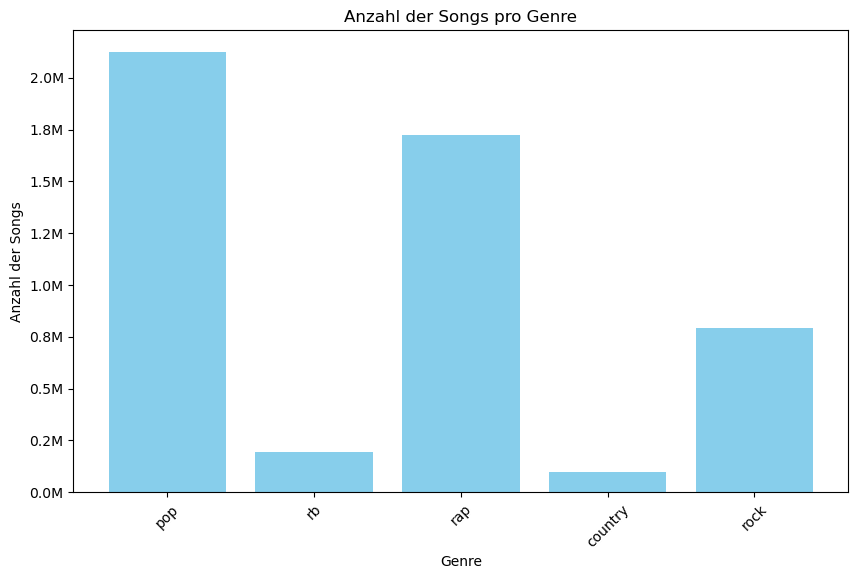

In [200]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

plt.figure(figsize=(10, 6))
plt.bar(pandas_df['genre'], pandas_df['count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Anzahl der Songs')
plt.title('Anzahl der Songs pro Genre')
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

In [201]:
genre_count_df = df_lyrics.groupBy("decade").count()
# Konvertiere das Ergebnis in ein Pandas DataFrame
pandas_df = genre_count_df.toPandas()

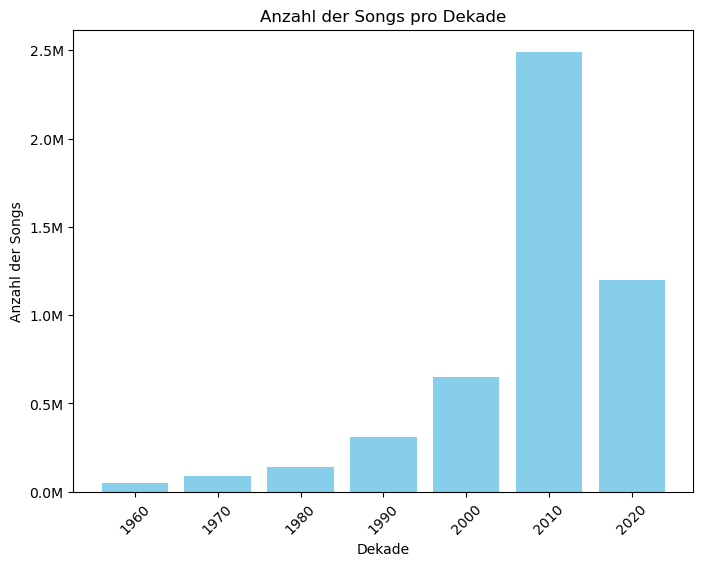

In [202]:
plt.figure(figsize=(8, 6))
plt.bar(pandas_df['decade'], pandas_df['count'], color='skyblue', width=8)
plt.xlabel('Dekade')
plt.ylabel('Anzahl der Songs')
plt.title('Anzahl der Songs pro Dekade')
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

In [203]:
df_top_artists = df_lyrics.groupBy("artist").agg(F.count("*").alias("num_songs")).orderBy(F.desc("num_songs"))

In [204]:
# filter Genius artists out
df_top_artists = df_top_artists.where(~F.col("artist").startswith("Genius"))

In [205]:
df_top_artists.show(truncate=False)

+-------------------------+---------+
|artist                   |num_songs|
+-------------------------+---------+
|The Grateful Dead        |2118     |
|Lil B                    |1323     |
|Polskie tumaczenia Genius|1322     |
|Tendon Levey             |1320     |
|Frank Zappa              |1317     |
|KIDZ BOP Kids            |1273     |
|Gucci Mane               |1243     |
|Lil Wayne                |1219     |
|Guided by Voices         |1207     |
|Juice WRLD               |1179     |
|Madonna                  |1019     |
|Vybz Kartel              |1004     |
|Muze Sikk                |967      |
|Mina                     |954      |
|Chief Keef               |947      |
|Willie Nelson            |947      |
|Johnny Cash              |942      |
|OCTOBERSFULLMOON         |941      |
|YOUNG DIAMOND            |904      |
|Bob Dylan                |892      |
+-------------------------+---------+
only showing top 20 rows



In [206]:
df_top_ten_artists = df_top_artists.limit(10)

In [207]:
df_top_ten_artists.show()

+--------------------+---------+
|              artist|num_songs|
+--------------------+---------+
|   The Grateful Dead|     2118|
|               Lil B|     1323|
|Polskie tumaczeni...|     1322|
|        Tendon Levey|     1320|
|         Frank Zappa|     1317|
|       KIDZ BOP Kids|     1273|
|          Gucci Mane|     1243|
|           Lil Wayne|     1219|
|    Guided by Voices|     1207|
|          Juice WRLD|     1179|
+--------------------+---------+



In [208]:
# num of songs grouped by year and genre
df_decade_genre = df_lyrics.groupBy("decade", "genre").agg(F.count("*").alias("num_songs"))

pd_decade_genre = df_decade_genre.toPandas()

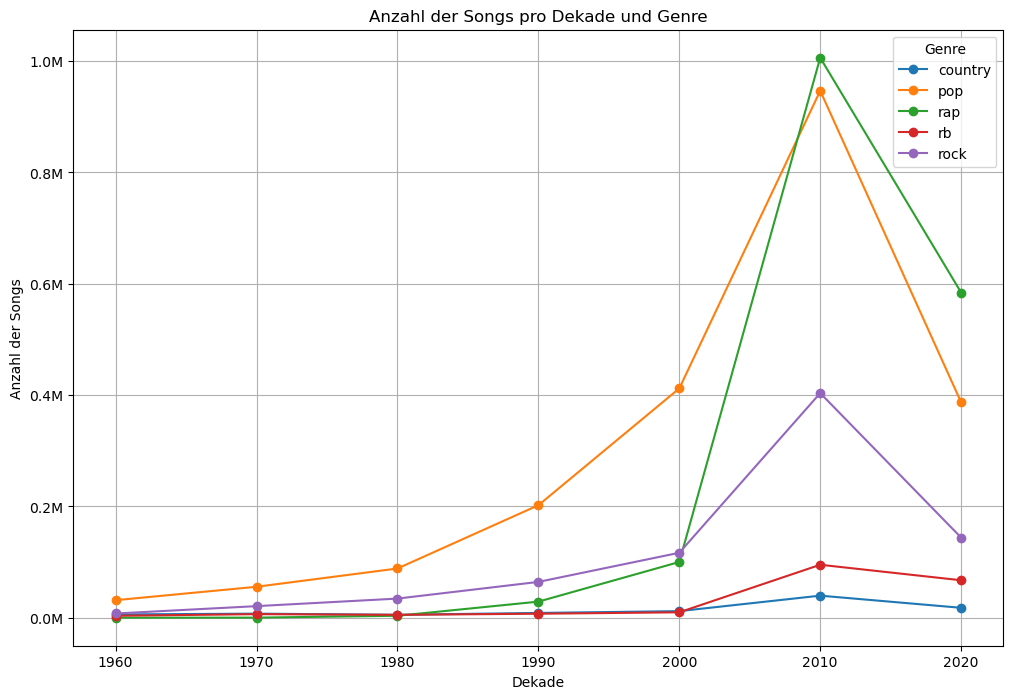

In [209]:
pivot_df = pd_decade_genre.pivot(index='decade', columns='genre', values='num_songs').fillna(0)

# Erstelle ein Liniendiagramm mit Matplotlib
plt.figure(figsize=(12, 8))

# Zeichne eine Linie für jedes Genre
for genre in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[genre], marker='o', label=genre)

plt.xlabel('Dekade')
plt.ylabel('Anzahl der Songs')
plt.title('Anzahl der Songs pro Dekade und Genre')
plt.legend(title='Genre')
plt.grid(True)

plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [210]:
# top artists depends on views
df_artists_views = df_lyrics.groupBy("artist").agg(F.sum("views").alias("all_time_views"))

In [211]:
df_lyrics.printSchema()

root
 |-- title: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- year: string (nullable = true)
 |-- views: integer (nullable = true)
 |-- features: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- decade: long (nullable = true)



In [212]:
df_artists_views.orderBy(F.desc("all_time_views")).show(truncate=False)

+---------------------------+--------------+
|artist                     |all_time_views|
+---------------------------+--------------+
|Drake                      |290237379     |
|Eminem                     |199737967     |
|Genius English Translations|165874183     |
|Kanye West                 |165229390     |
|Kendrick Lamar             |148417020     |
|Genius Romanizations       |130545372     |
|The Weeknd                 |118563064     |
|Taylor Swift               |97820856      |
|J. Cole                    |95488051      |
|XXXTENTACION               |90796415      |
|Ariana Grande              |74296327      |
|Travis Scott               |67476140      |
|Lil Wayne                  |65659151      |
|JAY-Z                      |63988435      |
|Frank Ocean                |61471754      |
|Beyonc                     |59400533      |
|Tyler, The Creator         |56832706      |
|Juice WRLD                 |55976231      |
|Ed Sheeran                 |55322373      |
|Billie Ei

In [214]:
pd_df = df_artists_views.orderBy(F.desc("all_time_views")).limit(10).toPandas()

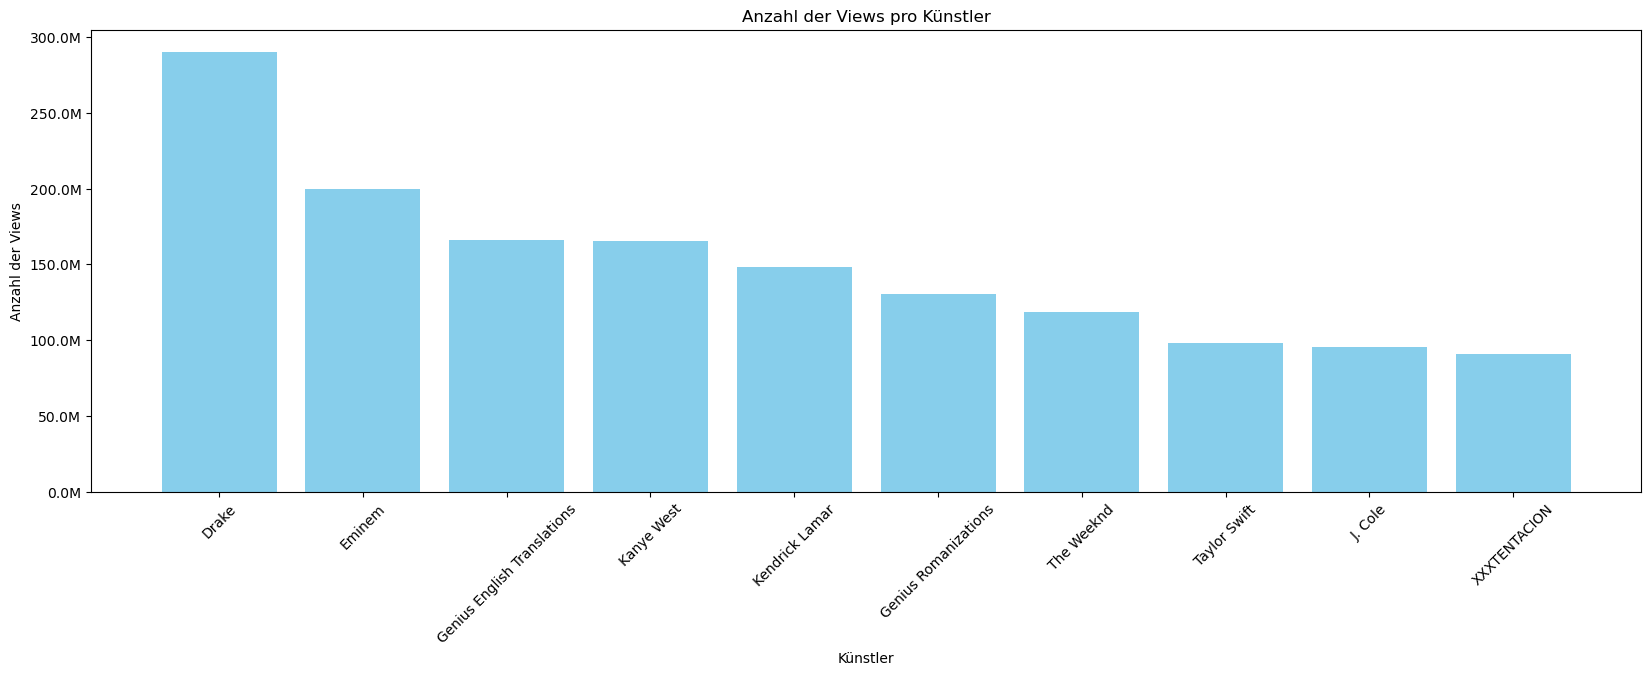

In [220]:
plt.figure(figsize=(20, 6))
plt.bar(pd_df['artist'], pd_df['all_time_views'], color='skyblue')
plt.xlabel('Künstler')
plt.ylabel('Anzahl der Views')
plt.title('Anzahl der Views pro Künstler')
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

In [221]:
df_lyrics.select("features").show(truncate=False)

+--------------------+
|features            |
+--------------------+
|{}                  |
|{"Mr. Mint"}        |
|{}                  |
|{"Sa Hoon (사훈)"}  |
|{"Paul McKenzie"}   |
|{}                  |
|{"Véronique Sanson"}|
|{}                  |
|{}                  |
|{}                  |
|{}                  |
|{}                  |
|{}                  |
|{}                  |
|{Ağaçkakan}         |
|{"Don Bustos"}      |
|{}                  |
|{}                  |
|{}                  |
|{}                  |
+--------------------+
only showing top 20 rows



In [227]:
df_lyrics.select("title", "year", "views", "features", "language").where(F.col("artist") == "Kollegah").orderBy(F.desc("views")).show(truncate=False)

+------------------------------+----+------+-------------------------+--------+
|title                         |year|views |features                 |language|
+------------------------------+----+------+-------------------------+--------+
|Mondfinsternis                |2011|800037|{}                       |de      |
|Bossaura                      |2011|464574|{}                       |de      |
|King                          |2014|404119|{}                       |de      |
|John Gotti                    |2015|360572|{}                       |de      |
|Alpha                         |2014|269689|{}                       |de      |
|Legacy                        |2017|266206|{}                       |de      |
|Genozid                       |2015|238875|{}                       |de      |
|AKs im Wandschrank            |2014|211234|{}                       |de      |
|Du bist Boss                  |2014|201866|{}                       |de      |
|Angeberprollrap Infinity Outro|2015|190

In [224]:
df_lyrics.groupBy("language").count().orderBy(F.desc("count")).show(500)

+--------+-------+
|language|  count|
+--------+-------+
|      en|3215494|
|      es| 270715|
|    null| 212615|
|      fr| 183869|
|      pt| 164222|
|      ru| 163410|
|      de| 154883|
|      it| 116980|
|      pl|  81612|
|      tr|  44036|
|      ja|  42471|
|      sv|  32474|
|      nl|  30910|
|      ko|  27897|
|      fi|  24189|
|      da|  18156|
|      he|  13809|
|      el|  11794|
|      ar|   9373|
|      cs|   9049|
|      no|   8937|
|      hu|   8694|
|      zh|   8684|
|      vi|   8597|
|      ro|   8431|
|      fa|   8413|
|     fil|   7122|
|      lv|   5098|
|      az|   4470|
|      sk|   4133|
|      ca|   3912|
|      id|   2702|
|      is|   2178|
|      uk|   2152|
|      bg|   2117|
|      lt|   1928|
|      hi|   1551|
|      et|   1515|
|      th|   1185|
|      af|   1158|
|      sq|   1032|
|      eu|    977|
|      ne|    955|
|      ta|    642|
|      bn|    557|
|      sl|    556|
|      mk|    537|
|      hr|    500|
|      ka|    406|
|      sr|  

In [63]:
df_dropped.count()

5089151